In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None 

zip_file = '/content/drive/MyDrive/bq-results-20210530-192920-mj4dg84mqhwg/bq-results-20210530-192920-mj4dg84mqhwg.csv'
raw_data = pd.read_csv(zip_file)
df = raw_data

In [4]:
raw_data.head()

,DevID,Gen_Voltage,Temp0,Temp1,BatBank0,BatBank1,CP,CT0,CT1,OnBatTime,DCPower,DCEnergy,GenRun_Alarm,GenBat_Alarm,Rectifier_Failure_Alarm,Door_Alarm,Battery_Alarm,Temp1BitC,Temp1BitB,Temp1BitA,Temp0BitC,Temp0BitB,Temp0BitA,Relay0,Relay1,Relay2,Relay3,Relay4,SysDT,Fuel_Ltrs
0,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-28.8,7571,1400,-1750240497,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,2019-01-01 00:00:05 UTC,NaN
1,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-29.8,7572,1454,-1750347441,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,2019-01-01 00:01:20 UTC,NaN
2,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-28.6,7573,1387,-1750450934,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,2019-01-01 00:02:35 UTC,NaN
3,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-29.2,7575,1422,-1750557145,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,2019-01-01 00:03:50 UTC,NaN
4,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-29.6,7575,1435,-1750579862,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,2019-01-01 00:04:06 UTC,NaN


In [5]:
# Import the data
df = pd.read_csv(zip_file, parse_dates={"DateTime":["SysDT"]},index_col=0)
df.head(3)

,DevID,Gen_Voltage,Temp0,Temp1,BatBank0,BatBank1,CP,CT0,CT1,OnBatTime,DCPower,DCEnergy,GenRun_Alarm,GenBat_Alarm,Rectifier_Failure_Alarm,Door_Alarm,Battery_Alarm,Temp1BitC,Temp1BitB,Temp1BitA,Temp0BitC,Temp0BitB,Temp0BitA,Relay0,Relay1,Relay2,Relay3,Relay4,Fuel_Ltrs
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:05+00:00,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-28.8,7571,1400,-1750240497,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN
2019-01-01 00:01:20+00:00,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-29.8,7572,1454,-1750347441,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN
2019-01-01 00:02:35+00:00,MT1080,1,27.6,24.5,12.5,48.4,1,0.1,-28.6,7573,1387,-1750450934,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN


# Fuel Forecasting

In [6]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
import pandas as pd  
from datetime import *  
from datetime import datetime  
import datetime as dt  
import time  

# Retrive the data

In [ ]:
# Import the data
df = pd.read_csv('MT1080_Full.csv', parse_dates={"DateTime":["SysDT"]},index_col=0)
#MT1080_Full.csv
#MT0150.csv
#MT0155.csv
#Sort ascending 
#df = df.sort_values(by=['DateTime'])
df.head(3)

,DevID,Fuel_Ltrs,Gen_Voltage,Temp0,Temp1,BatBank0,BatBank1,CP,CT0,CT1,...,Temp1BitB,Temp1BitA,Temp0BitC,Temp0BitB,Temp0BitA,Relay0,Relay1,Relay2,Relay3,Relay4
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:05+00:00,MT1080,NaN,1,27.6,24.5,12.5,48.4,1,0.1,-28.8,...,0,0,0,0,0,65536,0.0,0,0,0
2019-01-01 00:01:20+00:00,MT1080,NaN,1,27.6,24.5,12.5,48.4,1,0.1,-29.8,...,0,0,0,0,0,65536,0.0,0,0,0
2019-01-01 00:02:35+00:00,MT1080,NaN,1,27.6,24.5,12.5,48.4,1,0.1,-28.6,...,0,0,0,0,0,65536,0.0,0,0,0


# Data Exploration 

In [7]:
# check NULL values in a data frame.
df.Fuel_Ltrs.isnull().values.any()

True

In [8]:
df.shape

(393434, 29)

In [9]:
df.describe()

,Gen_Voltage,Temp0,Temp1,BatBank0,BatBank1,CP,CT0,CT1,OnBatTime,DCPower,DCEnergy,GenRun_Alarm,GenBat_Alarm,Rectifier_Failure_Alarm,Door_Alarm,Battery_Alarm,Temp1BitC,Temp1BitB,Temp1BitA,Temp0BitC,Temp0BitB,Temp0BitA,Relay0,Relay1,Relay2,Relay3,Relay4,Fuel_Ltrs
count,393434.000000,393434.000000,393434.000000,393434.000000,393434.000000,393434.000000,393434.000000,393434.000000,393434.000000,393434.000000,3.934340e+05,260258.000000,393434.000000,393434.000000,393434.000000,3.934340e+05,393434.0,393434.0,393434.0,393434.0,393434.0,393434.0,393434.000000,260258.0,393434.0,393434.0,393434.0,44692.000000
mean,47.724340,30.454175,29.422762,12.671963,48.780523,0.575936,5.622457,0.284104,37260.822695,961.742740,2.493714e+07,200.249291,0.990387,1.709120,16192.481179,4.833297e+07,0.0,0.0,0.0,0.0,0.0,0.0,65137.221084,0.0,0.0,0.0,0.0,220.602054
std,92.232938,3.269811,4.059559,1.401134,2.141740,0.995428,11.111123,45.119639,55700.955991,549.259675,1.198138e+09,406.147916,0.097573,0.705089,1761.014706,3.012469e+07,0.0,0.0,0.0,0.0,0.0,0.0,5096.608326,0.0,0.0,0.0,0.0,82.908424
min,0.000000,19.400000,19.100000,0.000000,44.300000,0.000000,0.000000,-42.800000,0.000000,0.000000,-2.147482e+09,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,63.000000
25%,0.000000,28.200000,26.600000,12.400000,47.500000,0.000000,0.100000,-28.800000,2964.000000,412.000000,-8.264495e+08,0.000000,1.000000,2.000000,16384.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,65536.000000,0.0,0.0,0.0,0.0,149.000000
50%,1.000000,30.500000,28.600000,12.500000,48.300000,1.000000,0.100000,-21.600000,7576.000000,1157.000000,-1.380721e+08,0.000000,1.000000,2.000000,16384.000000,6.710886e+07,0.0,0.0,0.0,0.0,0.0,0.0,65536.000000,0.0,0.0,0.0,0.0,221.000000
75%,1.000000,32.800000,31.500000,12.700000,49.300000,1.000000,0.100000,-0.800000,33814.000000,1400.000000,1.107928e+09,0.000000,1.000000,2.000000,16384.000000,6.710886e+07,0.0,0.0,0.0,0.0,0.0,0.0,65536.000000,0.0,0.0,0.0,0.0,291.000000
max,290.000000,39.400000,43.400000,14.500000,56.200000,374.000000,32.100000,116.600000,171198.000000,2486.000000,2.147447e+09,1024.000000,1.000000,2.000000,16384.000000,6.710886e+07,0.0,0.0,0.0,0.0,0.0,0.0,65536.000000,0.0,0.0,0.0,0.0,389.000000


In [12]:
# Select features related with generator and battery 
df1=df.iloc[:,:]
df1 = df1.rename({'Fuel_Ltrs': 'Fuel_Level','Gen_Voltage': 'Genset_Volt',
                  'Temp0': 'Room_Temp', 'Temp1': 'Battery_Temp',
                  'BatBank0': 'Genset_Bat_Volt', 'BatBank1': 'Solar_Bat_Volt',
                  'CP': 'Utility_Power_Volt', 'CT0': 'Genset_Cur', 
                  'CT1': 'Solar_Bat_Cur','OnBatTime': 'Battery_Dur',
                  'DCPower': 'DC_Power','DCEnergy': 'DC_Energy' }, axis=1) 
df1.drop('DevID', axis=1, inplace=True)  
df1.head(3)

,Genset_Volt,Room_Temp,Battery_Temp,Genset_Bat_Volt,Solar_Bat_Volt,Utility_Power_Volt,Genset_Cur,Solar_Bat_Cur,Battery_Dur,DC_Power,DC_Energy,GenRun_Alarm,GenBat_Alarm,Rectifier_Failure_Alarm,Door_Alarm,Battery_Alarm,Temp1BitC,Temp1BitB,Temp1BitA,Temp0BitC,Temp0BitB,Temp0BitA,Relay0,Relay1,Relay2,Relay3,Relay4,Fuel_Level
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:05+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-28.8,7571,1400,-1750240497,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN
2019-01-01 00:01:20+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-29.8,7572,1454,-1750347441,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN
2019-01-01 00:02:35+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-28.6,7573,1387,-1750450934,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN


Let’s explore the data further through visualization to understand the correlation between features.  

([<matplotlib.axis.YTick at 0x7efb93323850>,
 [Text(0, 0, 'Off'), Text(0, 0, 'On')])

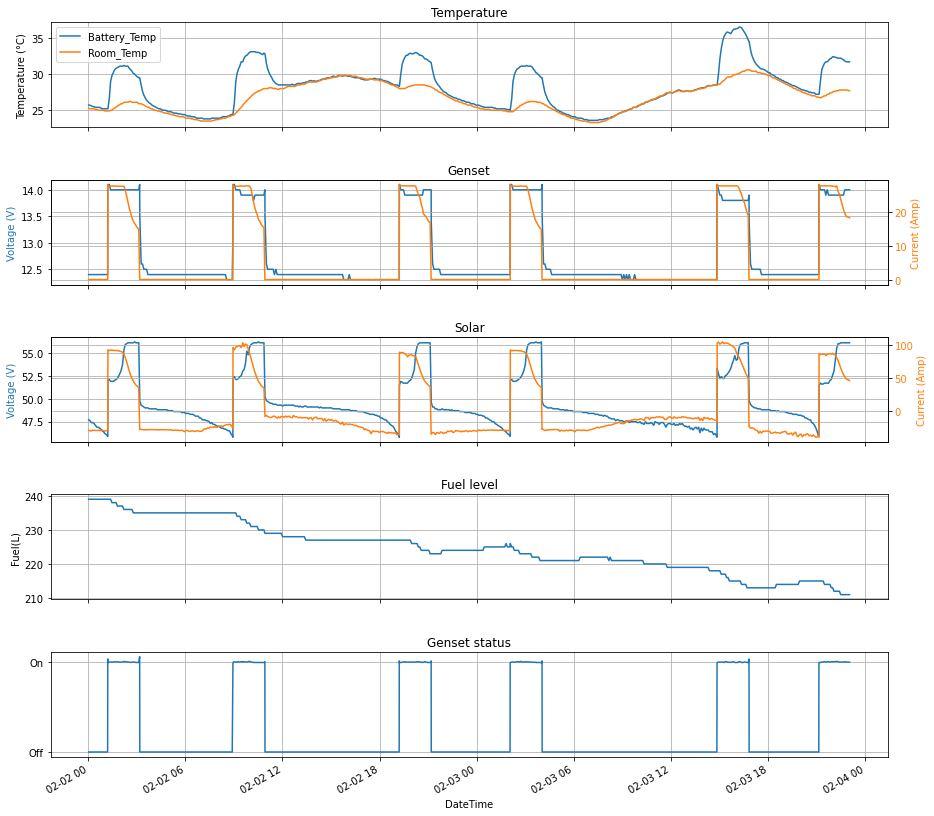

In [13]:
# Select observation of a single day. 
df_oneday=df1.loc['2021-02-02':'2021-02-03'].sort_index()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))

# Make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

ax1 =plt.subplot(511)
df_oneday.Battery_Temp.plot()
df_oneday.Room_Temp.plot()
ax1.grid(True)
ax1.set_ylabel('Temperature (°C)')
ax1.set_title('Temperature')
ax1.legend()

ax2 =plt.subplot(512,sharex=ax1)
color = 'tab:blue'
df_oneday.Genset_Bat_Volt.plot(color=color)
ax2.grid(True)
ax2.set_ylabel('Voltage (V)',color=color)
ax2.set_title('Genset')

#ax2.legend()
ax21 = ax2.twinx() 
color = 'tab:orange'
df_oneday.Genset_Cur.plot(color=color)
ax21.grid(True)
ax21.set_ylabel('Current (Amp)',color=color)
ax21.tick_params(axis='y', labelcolor=color)
#ax21.legend()

ax3 =plt.subplot(513, sharex=ax1)
color = 'tab:blue'
df_oneday.Solar_Bat_Volt.plot(color=color)
ax3.grid(True)
ax3.set_ylabel('Voltage (V)',color=color)
ax3.set_title('Solar')
#ax3.legend()
ax31 = ax3.twinx() 
color = 'tab:orange'
df_oneday.Solar_Bat_Cur.plot(color=color)
ax31.grid(True)
ax31.set_ylabel('Current (Amp)',color=color)
ax31.tick_params(axis='y', labelcolor=color)
#ax31.legend()

ax4 =plt.subplot(514, sharex=ax1)
df_oneday.Fuel_Level.plot()
ax4.grid(True)
ax4.set_ylabel('Fuel(L)')
ax4.set_title('Fuel level')

ax5 =plt.subplot(515, sharex=ax1)
df_oneday.Genset_Volt.plot()
ax5.grid(True)
ax5.set_title('Genset status')
ax5.set_yticks([1, 230])
plt.yticks([1,230], ['Off', 'On'])

It can be clearly seen from the chart that the value of all features, except fuel level, increases when the Genset is running. This phenomenon confirmed that these features are controlled by the Genset. 

The fuel level shall remain the same when the generator is in an off/inactive state. It is difficult to observe this fact from the above figure. To get more insight into the relationship between generator status and fuel level, both features need to be transformed into a common scale.

#### Apply min-max normalization to transform the data into a decimal between 0 and 1.  


In [14]:
#  min-max normalization
min_d = np.min(df_oneday)
max_d = np.max(df_oneday)
norm_feature = (df_oneday - min_d) / (max_d - min_d)
norm_feature.head(3)

,Genset_Volt,Room_Temp,Battery_Temp,Genset_Bat_Volt,Solar_Bat_Volt,Utility_Power_Volt,Genset_Cur,Solar_Bat_Cur,Battery_Dur,DC_Power,DC_Energy,GenRun_Alarm,GenBat_Alarm,Rectifier_Failure_Alarm,Door_Alarm,Battery_Alarm,Temp1BitC,Temp1BitB,Temp1BitA,Temp0BitC,Temp0BitB,Temp0BitA,Relay0,Relay1,Relay2,Relay3,Relay4,Fuel_Level
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-02 00:01:51+00:00,0.0,0.273973,0.162791,0.055556,0.182692,NaN,0.003559,0.071625,NaN,0.570962,1.000000,0.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2021-02-02 00:06:53+00:00,0.0,0.260274,0.162791,0.055556,0.173077,NaN,0.003559,0.068871,NaN,0.576672,0.997318,0.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2021-02-02 00:11:54+00:00,0.0,0.260274,0.155039,0.055556,0.153846,NaN,0.003559,0.066116,NaN,0.586052,0.994573,0.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


#### Let’s plot fuel level measurement and Genset voltage at 2021-02-02

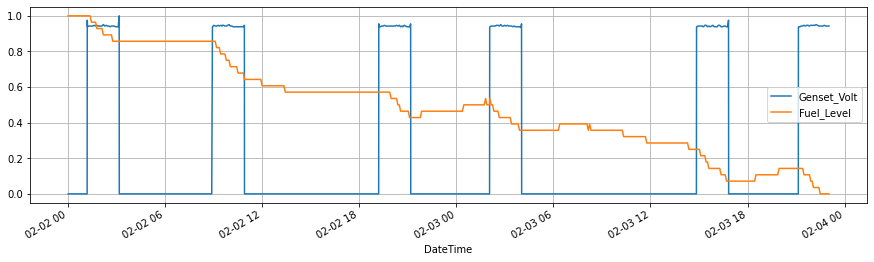

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
norm_feature.Genset_Volt.plot()
norm_feature.Fuel_Level.plot()
ax.grid(True)
ax.legend()

The fuel level is supposed to be steady when the generator is in an off state. However, as can be seen from the above figure, the fuel is unsteady when the generator is off. To understand more about the probable cause for the fuel level fluctuation, a line chart is plotted for the time where the generator was off (inactive).

First, let’s create features that show the status of the Genset and the fuel consumption.

In [16]:
# Add a feature that shows the status of the Genset.
def Gen_status(df):
    if (df['Genset_Volt'] > 1):
        return 'On'
    elif (df['Genset_Volt'] <= 1):
        return 'Off'
df1['Genset_Status'] = df1.apply(Gen_status, axis = 1)

# Add a feature that shows the status of the fuel consumption (a difference between the current  
# and the previous readings).

df1['Fuel_Level_Change']= df1['Fuel_Level'].diff()


# Add a feature that shows the rate of change of room temperature(a difference between the current  
# and the previous readings).

df1['Temp_Change']= df1['Room_Temp'].diff()
df1.head()

,Genset_Volt,Room_Temp,Battery_Temp,Genset_Bat_Volt,Solar_Bat_Volt,Utility_Power_Volt,Genset_Cur,Solar_Bat_Cur,Battery_Dur,DC_Power,DC_Energy,GenRun_Alarm,GenBat_Alarm,Rectifier_Failure_Alarm,Door_Alarm,Battery_Alarm,Temp1BitC,Temp1BitB,Temp1BitA,Temp0BitC,Temp0BitB,Temp0BitA,Relay0,Relay1,Relay2,Relay3,Relay4,Fuel_Level,Genset_Status,Fuel_Level_Change,Temp_Change
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:05+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-28.8,7571,1400,-1750240497,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN,Off,NaN,NaN
2019-01-01 00:01:20+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-29.8,7572,1454,-1750347441,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN,Off,NaN,0.0
2019-01-01 00:02:35+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-28.6,7573,1387,-1750450934,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN,Off,NaN,0.0
2019-01-01 00:03:50+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-29.2,7575,1422,-1750557145,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN,Off,NaN,0.0
2019-01-01 00:04:06+00:00,1,27.6,24.5,12.5,48.4,1,0.1,-29.6,7575,1435,-1750579862,0.0,1,2,16384,67108864,0,0,0,0,0,0,65536,0.0,0,0,0,NaN,Off,NaN,0.0


### Visualize the fuel level fluctuation while the Genset is off

For better understanding, it is vital to check the fluctuation of the fuel level readings at 5-minutes and an hour interval when the generator is in off status.

Let’s first consider the fuel level readings at 5-minutes.

Text(0.5, 1.0, 'Fuel level variation (Off status)')

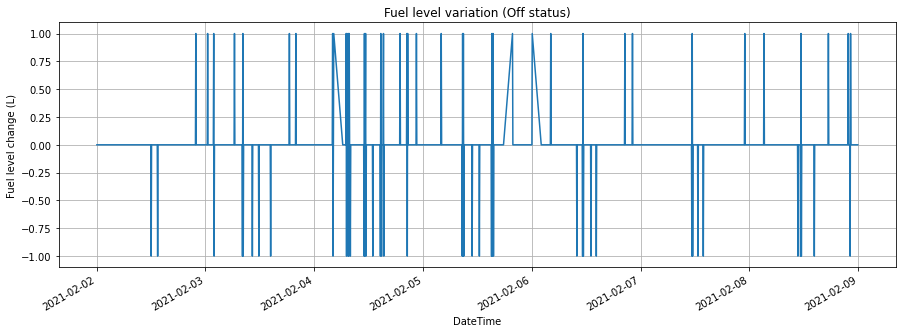

In [17]:
# Select the features when the Genset is off
df2=df1.loc[df1.Genset_Status=='Off']

# Select observation of a seven days. 

df_twodays_genoff=df2.loc['2021-02-02':'2021-02-08'].sort_index()

# Plot the fuel level
fig, ax = plt.subplots(figsize=(15, 5))
df_twodays_genoff.Fuel_Level_Change.plot()
ax.grid(True)
ax.set_ylabel('Fuel level change (L)')
ax.set_title('Fuel level variation (Off status)')

Now, let’s  consider the fuel level readings at an hour intervals.


Text(0.5, 1.0, 'Fuel level variation (Off status)')

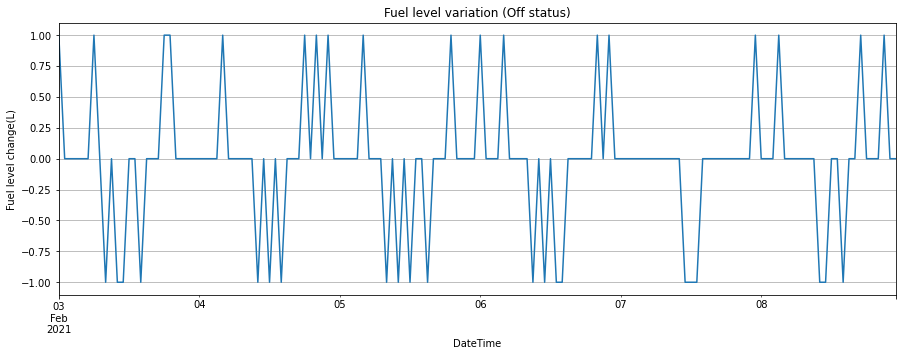

In [18]:
# Select the features when the Genset is off

df3=df1.loc[df1.Genset_Status=='Off']

#  convert the minute data into hourly
df_h = df3.groupby(pd.Grouper(freq='H')).sum()

# Select observation of a single day. 
df_oneday_genoff_hourly=df_h.loc['2021-02-03':'2021-02-08'].sort_index()

# Plot the fuel level
fig, ax = plt.subplots(figsize=(15, 5))
df_oneday_genoff_hourly.Fuel_Level_Change.plot()
ax.grid(True)
ax.set_ylabel('Fuel level change(L)')
ax.set_title('Fuel level variation (Off status)')



It is apparently seen from the above two figures that the fluctuation is limited to ±1 liter for both cases ( fuel level readings at 5-minutes and an hour interval). The number of ups and downs within the considered period for both cases is almost equal. This indicates that there is another factor that affects the fuel level reading.


#### Let's investigate the effect of temperature on fuel level readings.

Text(0.5, 0, 'Date')

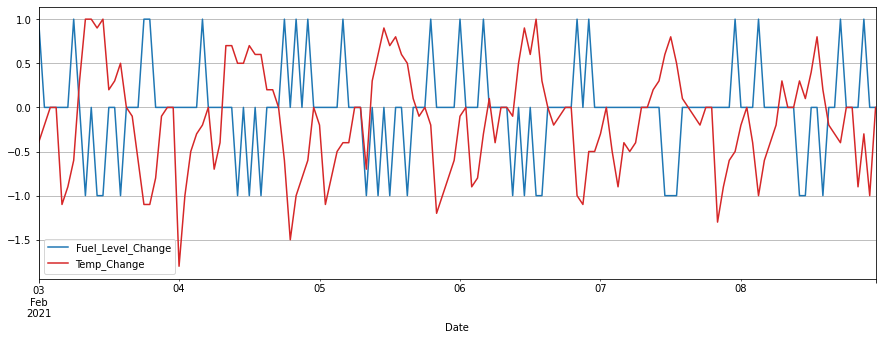

In [19]:

# Plot the rate of change of room temperature and the houly fuel levele at 2021-02-02

fig, ax = plt.subplots(figsize=(15, 5))
df_oneday_genoff_hourly.Fuel_Level_Change.plot()
color = 'tab:red'
df_oneday_genoff_hourly.Temp_Change.plot( color=color)
ax.grid(True)
ax.legend()
ax.set_xlabel('Date')


It can be observed from the above figure that when the temperature sharply increases, the reading of the fuel level decreases. Similarly, when the temperature decreases, an increment in the fuel level reading is observed. Hence, the fuel level fluctuation is probably caused by the variation in the temperature.

# Data preparation

# Mathimatical model 

#### Let's investigate the whole fuel level measurments 

In [20]:
df1.Fuel_Level_Change.describe()

count    44691.000000
mean        -0.005639
std          2.364779
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        227.000000
Name: Fuel_Level_Change, dtype: float64

On this site, there are **44,691** fuel level measurements taken every five minutes. Only a maximum of 2 liters of fuel consumption has been observed. Let's explore further to understand the cause for it. 

First, identify the date and time in which consumption of the 2 liters of fuel is observed. 

In [21]:
df1[df1.Fuel_Level_Change ==-2].index[:]

DatetimeIndex(['2020-12-29 22:25:04+00:00', '2021-01-08 11:34:31+00:00',
               '2021-03-22 02:19:33+00:00'],
              dtype='datetime64[ns, UTC]', name='DateTime', freq=None)

It can be seen from the above results, **there** are three days in which two liters of fuel consumption are observed.  Let's plot room temperature, generator voltage, and the fuel level change of these days after they are normalized to see any correlation.

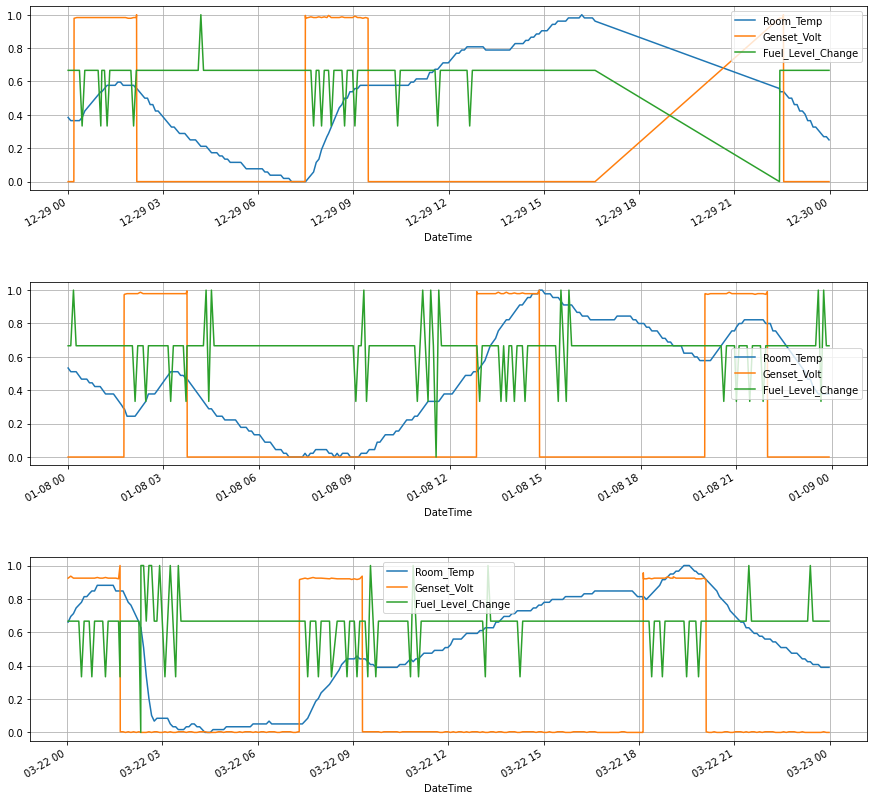

In [22]:
# Select observation of a single day. 
df_more_cons1=df1.loc['2020-12-29'].sort_index()
df_more_cons2=df1.loc['2021-01-08'].sort_index()
df_more_cons3=df1.loc['2021-03-22'].sort_index()

cols =['Genset_Volt','Fuel_Level_Change','Room_Temp']
df_more_cons_s1 = df_more_cons1[cols]
df_more_cons_s2 = df_more_cons2[cols]
df_more_cons_s3 = df_more_cons3[cols]

#  min-max normalization

norm_feature1 = (df_more_cons_s1-df_more_cons_s1.min())/(df_more_cons_s1.max()-df_more_cons_s1.min())
norm_feature2 = (df_more_cons_s2-df_more_cons_s2.min())/(df_more_cons_s2.max()-df_more_cons_s2.min())
norm_feature3 = (df_more_cons_s3-df_more_cons_s3.min())/(df_more_cons_s3.max()-df_more_cons_s3.min())

# plot the charts 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))

# Make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

ax1 =plt.subplot(3,1,1)
norm_feature1.Room_Temp.plot()
norm_feature1.Genset_Volt.plot()
norm_feature1.Fuel_Level_Change.plot()
ax1.grid(True)
ax1.legend()

ax2 =plt.subplot(3,1,2)
norm_feature2.Room_Temp.plot()
norm_feature2.Genset_Volt.plot()
norm_feature2.Fuel_Level_Change.plot()
ax2.grid(True)
ax2.legend()

ax3 =plt.subplot(3,1,3)
norm_feature3.Room_Temp.plot()
norm_feature3.Genset_Volt.plot()
norm_feature3.Fuel_Level_Change.plot()
ax3.grid(True)
ax3.legend()

It can be noticed from the first chart that, for some reason, there were not any measurements between around *4pm and 11pm.* From chart two and three, it can be observed that the two liters fuel reduction was observed while the generator is inactive. On this site, reduction of 2 liters of fuel happened only **twice** from *44000 plus readings*. 

In [23]:
# Drop the date and time in which 2 liters of fuel reduction observed due to the malfunction of the system on 2020-12-29 

df1=df1.drop(pd.Timestamp('2020-12-29 22:25:04+00:00'))

Let's examine the number of occurrence of  ± 1 liter of fuels  during the periods in which the Genset is not running

In [24]:
# Select the features when the Genset is off

df_GenOff=df1.loc[df1.Genset_Status=='Off']

print("Number of occurrence of -1 liters when the Genset is in an off state: {:.0f}"
      .format(len(df_GenOff[df_GenOff.Fuel_Level_Change == -1])))
print("Number of occurrence of +1 liters when the Genset is in an off state: {:.0f}"
      .format(len(df_GenOff[df_GenOff.Fuel_Level_Change == 1])))


Number of occurrence of -1 liters when the Genset is in an off state: 815
Number of occurrence of +1 liters when the Genset is in an off state: 763


The number of occurrences of ± 1 liter of fuel is quite comparable.  And as presented above, the reduction of 2 liters happened only twice from 44000 plus readings. **Thus, it can be assumed that only fluctuation of ± 1 liter of fuel is a normal phenomenon during the Genset is in an off state.** 

The fuel level change has been computed by taking the difference between the current and the previous readings. This feature can have a positive value because of two reasons: 
    1. the fuel level reading can fluctuate ±1 liter (as presented above), and
    2. the addition of fuel. 
**The positive values have to be handled before processing further by replacing them with zero. Indeed, values of fuel level change equal to or below -1 when the Genset is in an off state shall be replaced by zero.**

### <span style="color:blue"> Note: Depending on the site the fluctuation may be different than ±1, so it is a site specific </span>

In [25]:
# replace the positive fuel consumption values by zero
df_m= df1
df_m.loc[df_m.Fuel_Level_Change >= 1, 'Fuel_Level_Change'] = 0
df_m.loc[(df_m.Genset_Status=='Off') & (df_m.Fuel_Level_Change <= -1), 'Fuel_Level_Change'] = 0
df_m['Fuel_Level_Change'].describe()

count    44690.000000
mean        -0.043231
std          0.203379
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: Fuel_Level_Change, dtype: float64

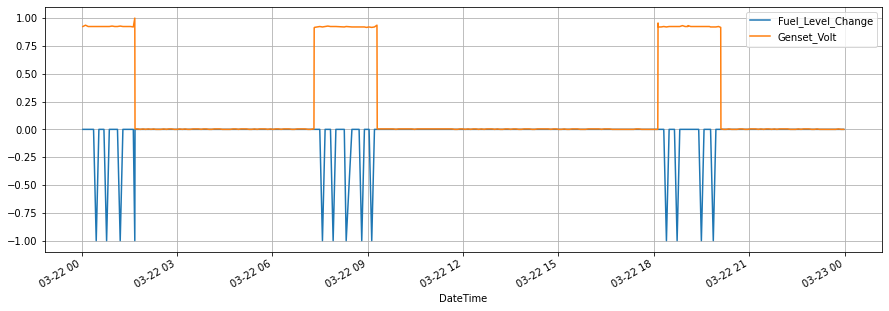

In [26]:
# Sanity check 

fig, (ax) = plt.subplots(figsize=(15,5))

dfm1=df_m.loc['2021-03-22'].sort_index()
dfm1.Fuel_Level_Change.plot(figsize=(15,5))
norm_feature3.Genset_Volt.plot() # it is a normailized value as the purpose it just for sanity check 
ax.grid(True)
ax.legend()

Select relevant features that affect the fuel consumption, which are equipment temperature, ambient temperature, Genset operational time.

In [27]:
# Select relevant features 
df_select=df_m.filter(["Genset_Status", "Room_Temp", "Battery_Temp",
                       'Genset_Bat_Volt','Genset_Cur',"Fuel_Level_Change"])

# Take the absolute value of fuel level change to covert it positive value (fuel consumption)
df_select['Fuel_Consumption'] = df_select['Fuel_Level_Change'].abs()

# Create a column by copying the index to calculate Genset runtime
df_select['index1'] = df_select.index

# Add a feature 'Genset_Runtime' which display the runtime of the Genset(a difference between the current  
# and the previous timesamps).
df_select['Genset_Runtime']= df_select['index1'].diff()

# Select the DF only when the Genset is running 
df_select=df_select.loc[(df_select.Genset_Status=='On')]
df_select.head(3)

,Genset_Status,Room_Temp,Battery_Temp,Genset_Bat_Volt,Genset_Cur,Fuel_Level_Change,Fuel_Consumption,index1,Genset_Runtime
DateTime,,,,,,,,,
2019-01-02 04:10:00+00:00,On,25.9,22.9,14.1,2.2,NaN,NaN,2019-01-02 04:10:00+00:00,0 days 00:00:26
2019-01-02 04:10:31+00:00,On,25.9,23.7,14.2,30.2,NaN,NaN,2019-01-02 04:10:31+00:00,0 days 00:00:31
2019-01-02 04:11:39+00:00,On,25.9,25.1,14.1,29.6,NaN,NaN,2019-01-02 04:11:39+00:00,0 days 00:01:08


In [28]:
# Convert the Genset runime to seconds
df_select['Genset_Run_Seconds'] = df_select['Genset_Runtime'].dt.total_seconds()

# Add a feature 'Genset_Load' (Power*Time)
df_select['Genset_Load'] = df_select['Genset_Bat_Volt']*df_select['Genset_Cur'] 
df_select.head(3)

,Genset_Status,Room_Temp,Battery_Temp,Genset_Bat_Volt,Genset_Cur,Fuel_Level_Change,Fuel_Consumption,index1,Genset_Runtime,Genset_Run_Seconds,Genset_Load
DateTime,,,,,,,,,,,
2019-01-02 04:10:00+00:00,On,25.9,22.9,14.1,2.2,NaN,NaN,2019-01-02 04:10:00+00:00,0 days 00:00:26,26.0,31.02
2019-01-02 04:10:31+00:00,On,25.9,23.7,14.2,30.2,NaN,NaN,2019-01-02 04:10:31+00:00,0 days 00:00:31,31.0,428.84
2019-01-02 04:11:39+00:00,On,25.9,25.1,14.1,29.6,NaN,NaN,2019-01-02 04:11:39+00:00,0 days 00:01:08,68.0,417.36


### <span style="color:blue">Note: start and end date might be different from site to site</span>. 

In [29]:
# Fliter only a period in which the fuel level measurement is available 
start = '2020-11-01'
end = '2021-03-31'

In [30]:
# Fliter only a period in which the fuel level measurement is available 
df_select_new=df_select.filter(['Genset_Load','Room_Temp','Battery_Temp','Fuel_Consumption','Genset_Run_Seconds'],
                               axis=1).loc[start:end]
df_select_new.head(3)

,Genset_Load,Room_Temp,Battery_Temp,Fuel_Consumption,Genset_Run_Seconds
DateTime,,,,,
2020-11-01 02:36:10+00:00,97.29,24.2,26.5,0.0,26.0
2020-11-01 02:41:18+00:00,262.26,24.2,27.7,0.0,308.0
2020-11-01 02:46:14+00:00,261.80,24.2,30.1,0.0,296.0


In [31]:
# Fliter only a period in which the fuel level measurement is available 
df_select_new=df_select.filter(['Genset_Load','Room_Temp','Battery_Temp','Fuel_Consumption','Genset_Run_Seconds'],
                               axis=1).loc['2020-11-01':'2021-03-31']
df_select_new.head()

,Genset_Load,Room_Temp,Battery_Temp,Fuel_Consumption,Genset_Run_Seconds
DateTime,,,,,
2020-11-01 02:36:10+00:00,97.29,24.2,26.5,0.0,26.0
2020-11-01 02:41:18+00:00,262.26,24.2,27.7,0.0,308.0
2020-11-01 02:46:14+00:00,261.80,24.2,30.1,0.0,296.0
2020-11-01 02:51:16+00:00,261.80,24.2,31.3,0.0,302.0
2020-11-01 02:56:18+00:00,260.40,24.3,31.7,0.0,302.0


Text(0.5, 1.0, 'Fuel consumption')

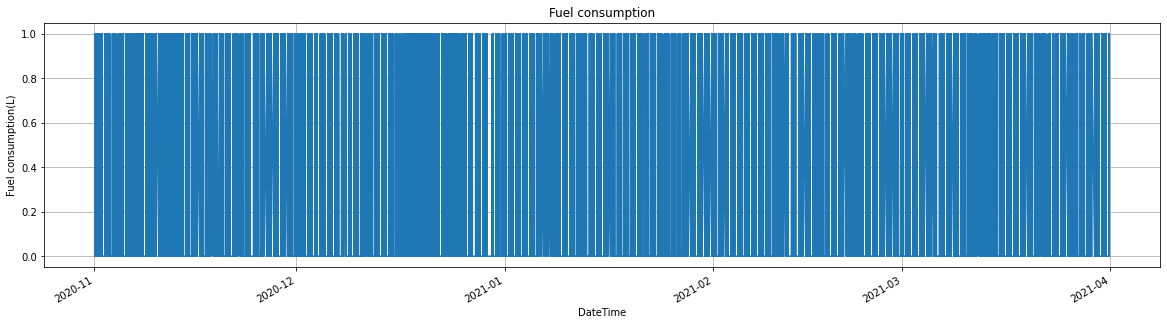

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))

df_select_new.Fuel_Consumption.plot()
ax.grid(True)
ax.set_ylabel('Fuel consumption(L)')
ax.set_title('Fuel consumption')

#### To see the fuel consumption trend, let’s convert the minute data into daily.

## Dailly statistics

#### Here, consider fule consumption per load and fuel burn rate

In [33]:
# Daily average genset load 
Genset_Load_daily = df_select_new['Genset_Load'].groupby(pd.Grouper(freq='D')).mean()

# Daily average room temperature 
Room_Temp_daily = df_select_new['Room_Temp'].groupby(pd.Grouper(freq='D')).mean()

# Daily average equipment temperatur in °C 
Battery_Temp_daily = df_select_new['Battery_Temp'].groupby(pd.Grouper(freq='D')).mean()

# Daily fuel consumption in liters  
Fuel_Cons_daily = df_select_new['Fuel_Consumption'].groupby(pd.Grouper(freq='D')).sum()

# Daily genset runtime in hours  
Runtime_daily = df_select_new['Genset_Run_Seconds'].groupby(pd.Grouper(freq='D')).sum()
Runtime_daily =  pd.DataFrame(Runtime_daily/3600)
Runtime_daily.columns=['Genset_Run_Hours']

# Daily fuel burn rate liter/hours in liters  
Fuel_Burn_Rate_daily= pd.DataFrame(Fuel_Cons_daily/Runtime_daily.Genset_Run_Hours)
Fuel_Burn_Rate_daily.columns=['Fuel_Burn_Rate']

# Daily fuel consumption per load  

Fuel_Cons_per_Load_daily = pd.DataFrame(Fuel_Cons_daily/Genset_Load_daily)
Fuel_Cons_per_Load_daily.columns=['Fuel_Cons_per_Load']

# Concatenate all 

Dataset_Daily = pd.concat([Fuel_Cons_daily,Genset_Load_daily,Room_Temp_daily, 
                     Battery_Temp_daily,Fuel_Burn_Rate_daily,Fuel_Cons_per_Load_daily,Runtime_daily], axis=1)

# Change the index name from DateTime to Date
Dataset_Daily.index.names = ['Date']
Dataset_Daily.head(3)

,Fuel_Consumption,Genset_Load,Room_Temp,Battery_Temp,Fuel_Burn_Rate,Fuel_Cons_per_Load,Genset_Run_Hours
Date,,,,,,,
2020-11-01 00:00:00+00:00,15.0,247.726224,25.686735,33.339796,1.933059,0.060551,7.759722
2020-11-02 00:00:00+00:00,10.0,249.714930,26.404225,34.139437,1.729107,0.040046,5.783333
2020-11-03 00:00:00+00:00,15.0,248.531134,25.890722,33.340206,1.936039,0.060355,7.747778


In [34]:
Dataset_Daily.describe()

,Fuel_Consumption,Genset_Load,Room_Temp,Battery_Temp,Fuel_Burn_Rate,Fuel_Cons_per_Load,Genset_Run_Hours
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,12.794702,303.405930,27.226495,32.523430,2.160772,0.042718,5.976415
std,1.793759,29.354861,2.183078,2.177038,0.261201,0.008316,0.933568
min,8.000000,235.843222,22.484298,28.349367,0.909985,0.024784,4.132222
25%,12.000000,300.078835,25.636674,31.108092,2.025658,0.038077,5.601528
50%,13.000000,315.288246,27.026667,32.048750,2.194710,0.041660,5.920000
75%,14.000000,322.745377,28.784297,33.634040,2.359054,0.046222,5.995556
max,18.000000,341.081067,31.862025,37.568354,2.701308,0.073289,9.890278


### Visualize daily average fuel consumption and other features

Text(0.5, 1.0, 'Daily Average Genset Runtime')

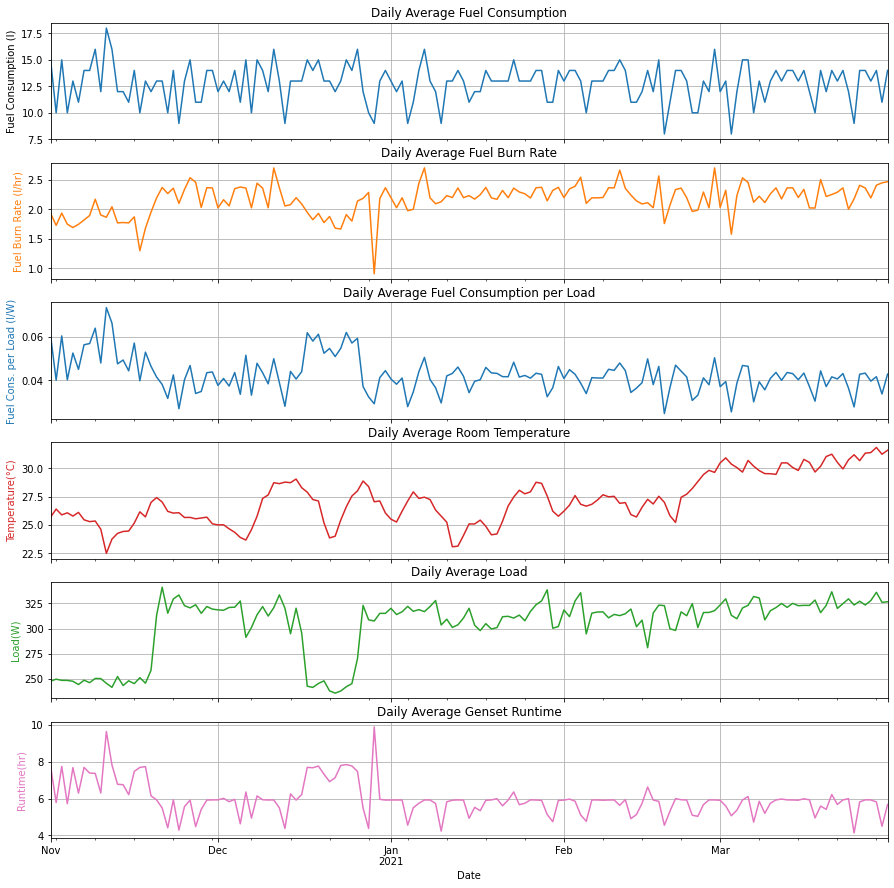

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(15,15))

# Make a little extra space between the subplots
fig.subplots_adjust(hspace=0.2)

ax1 =plt.subplot(611)
Dataset_Daily.Fuel_Consumption.plot()
ax1.grid(True)
ax1.set_ylabel('Fuel Consumption (l)')
ax1.set_title('Daily Average Fuel Consumption')

ax2 =plt.subplot(612,sharex=ax1)
color = 'tab:orange'
Dataset_Daily.Fuel_Burn_Rate.plot(color=color)
ax2.grid(True)
ax2.set_ylabel('Fuel Burn Rate (l/hr)',color=color)
ax2.set_title('Daily Average Fuel Burn Rate')

ax3 =plt.subplot(613, sharex=ax1)
color = 'tab:blue'
Dataset_Daily.Fuel_Cons_per_Load.plot(color=color)
ax3.grid(True)
ax3.set_ylabel('Fuel Cons. per Load (l/W)',color=color)
ax3.set_title('Daily Average Fuel Consumption per Load')

ax4 =plt.subplot(614, sharex=ax1)
color = 'tab:red'
Dataset_Daily.Room_Temp.plot(color=color)
ax4.grid(True)
ax4.set_ylabel('Temperature(°C)',color=color)
ax4.set_title('Daily Average Room Temperature')

ax5 =plt.subplot(615, sharex=ax1)
color = 'tab:green'
Dataset_Daily.Genset_Load.plot(color=color)
ax5.grid(True)
ax5.set_ylabel('Load(W)',color=color)
ax5.set_title('Daily Average Load')

ax6 =plt.subplot(616, sharex=ax1)
color = 'tab:pink'
Dataset_Daily.Genset_Run_Hours.plot(color=color)
ax6.grid(True)
ax6.set_ylabel('Runtime(hr)',color=color)
ax6.set_title('Daily Average Genset Runtime')

## Consider fule consumption per energy

In [36]:
Fuel_Cons_per_energy_daily=pd.DataFrame(Dataset_Daily.Fuel_Consumption/(Dataset_Daily.Genset_Load*Dataset_Daily.Genset_Run_Hours))
Fuel_Cons_per_energy_daily.columns=['Fuel_Cons_per_energy']

#Fuel_Cons_per_energy_daily
Dataset_Daily_E = pd.concat([Dataset_Daily,Fuel_Cons_per_energy_daily], axis=1)
Dataset_Daily_E.head(2)

,Fuel_Consumption,Genset_Load,Room_Temp,Battery_Temp,Fuel_Burn_Rate,Fuel_Cons_per_Load,Genset_Run_Hours,Fuel_Cons_per_energy
Date,,,,,,,,
2020-11-01 00:00:00+00:00,15.0,247.726224,25.686735,33.339796,1.933059,0.060551,7.759722,0.007803
2020-11-02 00:00:00+00:00,10.0,249.714930,26.404225,34.139437,1.729107,0.040046,5.783333,0.006924




#### For better visualization of all the features, let’s convert the data into the same scale first and then make a plot.


In [37]:
# normailize the dataset (min-max)
Dataset_Daily_norm = (Dataset_Daily_E-Dataset_Daily_E.min())/(Dataset_Daily_E.max()-Dataset_Daily_E.min())
Dataset_Daily_norm.head(2)

,Fuel_Consumption,Genset_Load,Room_Temp,Battery_Temp,Fuel_Burn_Rate,Fuel_Cons_per_Load,Genset_Run_Hours,Fuel_Cons_per_energy
Date,,,,,,,,
2020-11-01 00:00:00+00:00,0.7,0.112916,0.341494,0.541321,0.571127,0.737387,0.629987,0.848143
2020-11-02 00:00:00+00:00,0.2,0.131813,0.418004,0.628059,0.457272,0.314642,0.286748,0.694262


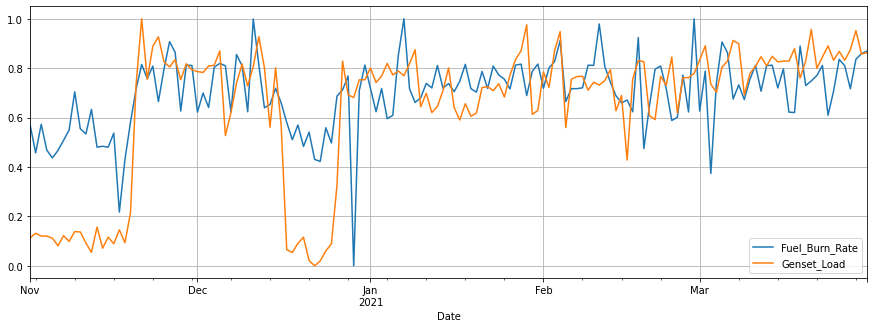

In [38]:
# plot Fuel Burn Rate and Genset Load

fig, (ax) = plt.subplots(figsize=(15,5))
Dataset_Daily_norm.Fuel_Burn_Rate.plot()
Dataset_Daily_norm.Genset_Load.plot()
ax.grid(True)
ax.legend()

It can be noticed that there is a strong positive correlation between the fuel burn rate and genset load. The fuel burn rate was calculated by considering the fuel consumption and the operation time.

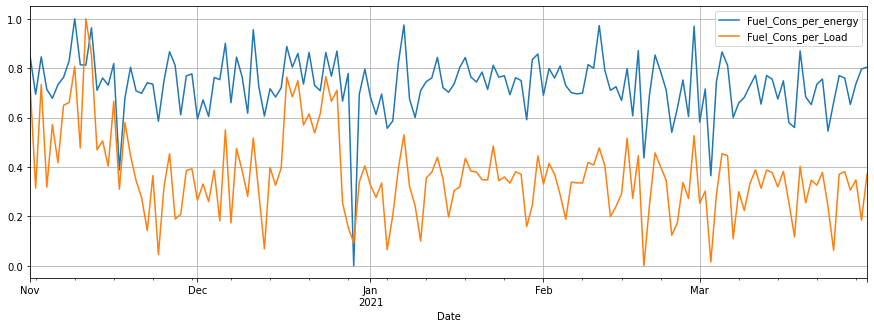

In [39]:
# plot Fuel Consumption per Energy anf Fuel Consumption per Load 

fig, (ax) = plt.subplots(figsize=(15,5))
Dataset_Daily_norm.Fuel_Cons_per_energy.plot()
Dataset_Daily_norm.Fuel_Cons_per_Load.plot()
ax.grid(True)
ax.legend()

A strong positive correlation between the fuel consumption per energy and fuel consumption per load can be observed. It an expected phenomenon.

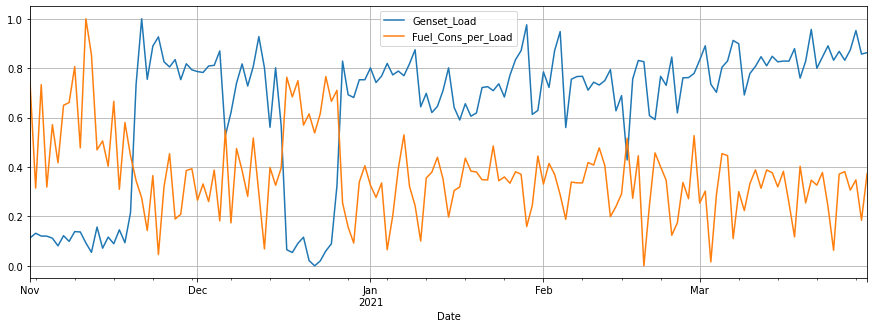

In [40]:
# plot Genset load and Fuel Consumption per Load

fig, (ax) = plt.subplots(figsize=(15,5))
Dataset_Daily_norm.Genset_Load.plot()
Dataset_Daily_norm.Fuel_Cons_per_Load.plot()
ax.grid(True)
ax.legend()

A strong negative correlation between the genset load and fuel consumption per load is observed. It an expected phenomenon as fuel consumption per load has negative relation with the genset load.

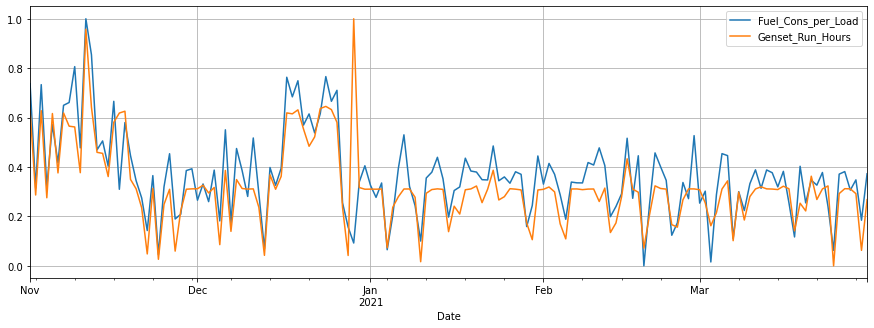

In [41]:
# plot Fuel Consumption per Load and Genset runtime 
fig, (ax) = plt.subplots(figsize=(15,5))
Dataset_Daily_norm.Fuel_Cons_per_Load.plot()
Dataset_Daily_norm.Genset_Run_Hours.plot()
ax.grid(True)
ax.legend()

There is a strong correlation between fuel consumption per load and genset run hours.

## Heatmap

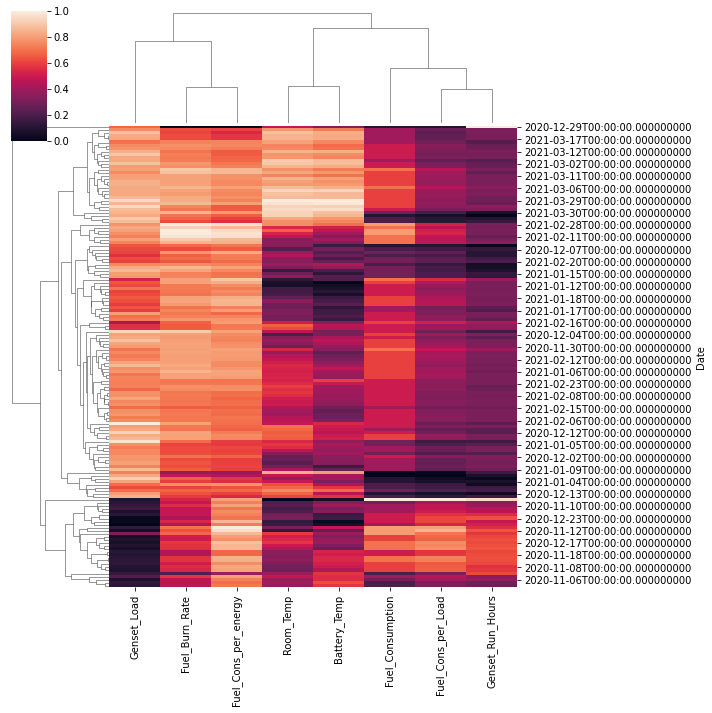

In [42]:
# Consider all the eight features 
# Plot the heatmap of the variable's correlation matrix
fig = sns.clustermap(Dataset_Daily_norm,
               row_cluster=True,
               col_cluster=True,
               figsize=(10, 10));
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

Features "room and battery temperature", "fuel burn rate and fuel consumption per energy", as well as "fuel consumption per load and genset run hours" are clustered together. This mean that all the features clustered together has strong dependencies and considering one feature from each group as a predictor feature would be sufficient enough.  

Let's drop features correlated with each other

In [44]:
# Drop features correlated with each other
Data=Dataset_Daily_E.drop(['Fuel_Burn_Rate','Battery_Temp','Genset_Run_Hours'], axis=1)
Data.head(2)

,Fuel_Consumption,Genset_Load,Room_Temp,Fuel_Cons_per_Load,Fuel_Cons_per_energy
Date,,,,,
2020-11-01 00:00:00+00:00,15.0,247.726224,25.686735,0.060551,0.007803
2020-11-02 00:00:00+00:00,10.0,249.714930,26.404225,0.040046,0.006924


Define a function to reshape the data to the format that suits for  LSTM training.

In [69]:
# convert series to supervised learning
def series_to_supervised(data, num_in=1, num_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# input sequence (t-n, ... t-1)
    for i in range(num_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, num_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [58]:
type(data)

numpy.ndarray

In [63]:
data = scaled
num_in = num_lag_days #25
num_out = 1

In [62]:
df = DataFrame(data)
df

,0,1,2,3,4
0,0.7,0.112916,0.341494,0.737387,0.848143
1,0.2,0.131813,0.418004,0.314642,0.694262
2,0.7,0.120564,0.363246,0.733344,0.845817
3,0.2,0.120123,0.382601,0.318729,0.714053
4,0.5,0.112005,0.351813,0.571358,0.678472
...,...,...,...,...,...
146,0.6,0.832075,0.946023,0.381505,0.759973
147,0.5,0.874295,0.951798,0.306526,0.653367
148,0.6,0.952199,1.000000,0.347932,0.736458
149,0.3,0.857135,0.935596,0.184590,0.796518


In [64]:
for i in range(num_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
names

['var1(t-25)',
 'var2(t-25)',
 'var3(t-25)',
 'var4(t-25)',
 'var5(t-25)',
 'var1(t-24)',
 'var2(t-24)',
 'var3(t-24)',
 'var4(t-24)',
 'var5(t-24)',
 'var1(t-23)',
 'var2(t-23)',
 'var3(t-23)',
 'var4(t-23)',
 'var5(t-23)',
 'var1(t-22)',
 'var2(t-22)',
 'var3(t-22)',
 'var4(t-22)',
 'var5(t-22)',
 'var1(t-21)',
 'var2(t-21)',
 'var3(t-21)',
 'var4(t-21)',
 'var5(t-21)',
 'var1(t-20)',
 'var2(t-20)',
 'var3(t-20)',
 'var4(t-20)',
 'var5(t-20)',
 'var1(t-19)',
 'var2(t-19)',
 'var3(t-19)',
 'var4(t-19)',
 'var5(t-19)',
 'var1(t-18)',
 'var2(t-18)',
 'var3(t-18)',
 'var4(t-18)',
 'var5(t-18)',
 'var1(t-17)',
 'var2(t-17)',
 'var3(t-17)',
 'var4(t-17)',
 'var5(t-17)',
 'var1(t-16)',
 'var2(t-16)',
 'var3(t-16)',
 'var4(t-16)',
 'var5(t-16)',
 'var1(t-15)',
 'var2(t-15)',
 'var3(t-15)',
 'var4(t-15)',
 'var5(t-15)',
 'var1(t-14)',
 'var2(t-14)',
 'var3(t-14)',
 'var4(t-14)',
 'var5(t-14)',
 'var1(t-13)',
 'var2(t-13)',
 'var3(t-13)',
 'var4(t-13)',
 'var5(t-13)',
 'var1(t-12)',
 'var2(t-1

In [65]:
for i in range(0, num_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
names

['var1(t-25)',
 'var2(t-25)',
 'var3(t-25)',
 'var4(t-25)',
 'var5(t-25)',
 'var1(t-24)',
 'var2(t-24)',
 'var3(t-24)',
 'var4(t-24)',
 'var5(t-24)',
 'var1(t-23)',
 'var2(t-23)',
 'var3(t-23)',
 'var4(t-23)',
 'var5(t-23)',
 'var1(t-22)',
 'var2(t-22)',
 'var3(t-22)',
 'var4(t-22)',
 'var5(t-22)',
 'var1(t-21)',
 'var2(t-21)',
 'var3(t-21)',
 'var4(t-21)',
 'var5(t-21)',
 'var1(t-20)',
 'var2(t-20)',
 'var3(t-20)',
 'var4(t-20)',
 'var5(t-20)',
 'var1(t-19)',
 'var2(t-19)',
 'var3(t-19)',
 'var4(t-19)',
 'var5(t-19)',
 'var1(t-18)',
 'var2(t-18)',
 'var3(t-18)',
 'var4(t-18)',
 'var5(t-18)',
 'var1(t-17)',
 'var2(t-17)',
 'var3(t-17)',
 'var4(t-17)',
 'var5(t-17)',
 'var1(t-16)',
 'var2(t-16)',
 'var3(t-16)',
 'var4(t-16)',
 'var5(t-16)',
 'var1(t-15)',
 'var2(t-15)',
 'var3(t-15)',
 'var4(t-15)',
 'var5(t-15)',
 'var1(t-14)',
 'var2(t-14)',
 'var3(t-14)',
 'var4(t-14)',
 'var5(t-14)',
 'var1(t-13)',
 'var2(t-13)',
 'var3(t-13)',
 'var4(t-13)',
 'var5(t-13)',
 'var1(t-12)',
 'var2(t-1

In [68]:
# put it all together
agg = concat(cols, axis=1)
agg.columns = names
dropnan = True
# drop rows with NaN values
if dropnan:
        agg.dropna(inplace=True)
agg

,var1(t-25),var2(t-25),var3(t-25),var4(t-25),var5(t-25),var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),var5(t-22),var1(t-21),var2(t-21),var3(t-21),var4(t-21),var5(t-21),var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),var5(t-19),var1(t-18),var2(t-18),var3(t-18),var4(t-18),var5(t-18),...,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
25,0.7,0.112916,0.341494,0.737387,0.848143,0.2,0.131813,0.418004,0.314642,0.694262,0.7,0.120564,0.363246,0.733344,0.845817,0.2,0.120123,0.382601,0.318729,0.714053,0.5,0.112005,0.351813,0.571358,0.678472,0.3,0.081052,0.386496,0.417055,0.733331,0.6,0.121964,0.316634,0.649702,0.762954,0.6,0.098957,0.299452,0.661114,0.829401,...,0.4,0.215563,0.481021,0.445988,0.804072,0.5,0.734705,0.527050,0.344874,0.707975,0.5,1.000000,0.484379,0.274820,0.698361,0.2,0.754909,0.396226,0.142933,0.741140,0.6,0.889324,0.379894,0.365183,0.735073,0.1,0.926758,0.383575,0.045618,0.585003,0.5,0.825893,0.338586,0.319428,0.749447,0.7,0.804886,0.339443,0.453789,0.866796
26,0.2,0.131813,0.418004,0.314642,0.694262,0.7,0.120564,0.363246,0.733344,0.845817,0.2,0.120123,0.382601,0.318729,0.714053,0.5,0.112005,0.351813,0.571358,0.678472,0.3,0.081052,0.386496,0.417055,0.733331,0.6,0.121964,0.316634,0.649702,0.762954,0.6,0.098957,0.299452,0.661114,0.829401,0.8,0.138530,0.305300,0.806276,1.000000,...,0.5,0.734705,0.527050,0.344874,0.707975,0.5,1.000000,0.484379,0.274820,0.698361,0.2,0.754909,0.396226,0.142933,0.741140,0.6,0.889324,0.379894,0.365183,0.735073,0.1,0.926758,0.383575,0.045618,0.585003,0.5,0.825893,0.338586,0.319428,0.749447,0.7,0.804886,0.339443,0.453789,0.866796,0.3,0.834667,0.326127,0.189671,0.811381
27,0.7,0.120564,0.363246,0.733344,0.845817,0.2,0.120123,0.382601,0.318729,0.714053,0.5,0.112005,0.351813,0.571358,0.678472,0.3,0.081052,0.386496,0.417055,0.733331,0.6,0.121964,0.316634,0.649702,0.762954,0.6,0.098957,0.299452,0.661114,0.829401,0.8,0.138530,0.305300,0.806276,1.000000,0.4,0.137236,0.227769,0.477504,0.813730,...,0.5,1.000000,0.484379,0.274820,0.698361,0.2,0.754909,0.396226,0.142933,0.741140,0.6,0.889324,0.379894,0.365183,0.735073,0.1,0.926758,0.383575,0.045618,0.585003,0.5,0.825893,0.338586,0.319428,0.749447,0.7,0.804886,0.339443,0.453789,0.866796,0.3,0.834667,0.326127,0.189671,0.811381,0.3,0.753548,0.333726,0.208650,0.611018
28,0.2,0.120123,0.382601,0.318729,0.714053,0.5,0.112005,0.351813,0.571358,0.678472,0.3,0.081052,0.386496,0.417055,0.733331,0.6,0.121964,0.316634,0.649702,0.762954,0.6,0.098957,0.299452,0.661114,0.829401,0.8,0.138530,0.305300,0.806276,1.000000,0.4,0.137236,0.227769,0.477504,0.813730,1.0,0.092751,0.000000,1.000000,0.812322,...,0.2,0.754909,0.396226,0.142933,0.741140,0.6,0.889324,0.379894,0.365183,0.735073,0.1,0.926758,0.383575,0.045618,0.585003,0.5,0.825893,0.338586,0.319428,0.749447,0.7,0.804886,0.339443,0.453789,0.866796,0.3,0.834667,0.326127,0.189671,0.811381,0.3,0.753548,0.333726,0.208650,0.611018,0.6,0.817856,0.341576,0.385654,0.768627
29,0.5,0.112005,0.351813,0.571358,0.678472,0.3,0.081052,0.386496,0.417055,0.733331,0.6,0.121964,0.316634,0.649702,0.762954,0.6,0.098957,0.299452,0.661114,0.829401,0.8,0.138530,0.305300,0.806276,1.000000,0.4,0.137236,0.227769,0.477504,0.813730,1.0,0.092751,0.000000,1.000000,0.812322,0.8,0.054720,0.134414,0.854364,0.963386,...,0.6,0.889324,0.379894,0.365183,0.735073,0.1,0.926758,0.383575,0.045618,0.585003,0.5,0.825893,0.338586,0.319428,0.749447,0.7,0.804886,0.339443,0.453789,0.866796,0.3,0.834667,0.326127,0.189671,0.811381,0.3,0.753548,0.333726,0.208650,0.611018,0.6,0.8178

Prepare data for lstm


In [70]:
# load dataset
df_values = Data.values

# conver all data values to float
df_values = df_values.astype('float32')
print(df_values[:5])
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_values)
print(scaled[:5])
# specify the number of lag days
num_lag_days = 25

# specify the number of predictors 
num_predictors  = Data.shape[1]
print(num_predictors)
# frame as supervised learning
reframed = series_to_supervised(scaled, num_lag_days, 1)
print(reframed.shape)

[[1.5000000e+01 2.4772623e+02 2.5686735e+01 6.0550716e-02 7.8032063e-03]
 [1.0000000e+01 2.4971494e+02 2.6404226e+01 4.0045664e-02 6.9243223e-03]
 [1.5000000e+01 2.4853113e+02 2.5890722e+01 6.0354613e-02 7.7899257e-03]
 [1.0000000e+01 2.4848473e+02 2.6072222e+01 4.0243924e-02 7.0373598e-03]
 [1.3000000e+01 2.4763042e+02 2.5783504e+01 5.2497592e-02 6.8341405e-03]]
[[0.7        0.11291575 0.34149408 0.7373866  0.8481427 ]
 [0.19999999 0.13181305 0.41800427 0.31464195 0.69426185]
 [0.7        0.12056422 0.36324644 0.7333436  0.8458174 ]
 [0.19999999 0.12012315 0.38260078 0.3187294  0.7140532 ]
 [0.50000006 0.11200523 0.35181308 0.57135844 0.6784722 ]]
5
(126, 130)


 ### <span style="color:blue"> Note: Depending on the number of observations and number of days to be forecasted, the “num_lag_days” can be changed. The larger number of lag days could enhance the accuracy of the forecast </span>

In [117]:
# split the data into train and test sets
df_values = reframed.values
n_train_days = int(0.85* len(df_values))
train = df_values[:n_train_days, :]
test = df_values[n_train_days:, :]

In [77]:
print('training set  length: ', len(train))
print('testing set  length: ', len(test))

training set  length:  107
testing set  length:  19


 ### <span style="color:blue"> Note: The top 85% of the timeseries data is used to train the model and the bottom 15% of the data is adopted to evaluate the performance of the trained (fuel forecasting). Once, the performance of the model is tested, then 100% of the data could be used to train the model and forecast the fuel consumption in the future.</span>

In [79]:
# split the data into input and outputs
num_obs = num_lag_days * num_predictors
num_obs

125

In [80]:
train_X, train_y = train[:, :num_obs], train[:, -num_predictors]

In [88]:
train[0, -1]

0.86679584

In [84]:
train_y

array([0.7       , 0.3       , 0.3       , 0.59999996, 0.59999996,
       0.40000004, 0.50000006, 0.40000004, 0.59999996, 0.3       ,
       0.7       , 0.19999999, 0.7       , 0.59999996, 0.40000004,
       0.8       , 0.50000006, 0.10000002, 0.50000006, 0.50000006,
       0.50000006, 0.7       , 0.59999996, 0.7       , 0.50000006,
       0.50000006, 0.40000004, 0.50000006, 0.7       , 0.59999996,
       0.8       , 0.40000004, 0.19999999, 0.10000002, 0.50000006,
       0.59999996, 0.50000006, 0.40000004, 0.50000006, 0.10000002,
       0.3       , 0.59999996, 0.8       , 0.50000006, 0.40000004,
       0.10000002, 0.50000006, 0.50000006, 0.59999996, 0.50000006,
       0.3       , 0.40000004, 0.40000004, 0.59999996, 0.50000006,
       0.50000006, 0.50000006, 0.50000006, 0.7       , 0.50000006,
       0.50000006, 0.50000006, 0.59999996, 0.59999996, 0.3       ,
       0.3       , 0.59999996, 0.50000006, 0.59999996, 0.59999996,
       0.50000006, 0.19999999, 0.50000006, 0.50000006, 0.50000

In [118]:
# split the data into input and outputs
num_obs = num_lag_days * num_predictors ## 25 * 5  = 125
train_X, train_y = train[:, :num_obs], train[:, -num_predictors]
test_X, test_y = test[:, :num_obs], test[:, -num_predictors]
print('Train input')
print(train_X.shape, len(train_X), train_y.shape)

Train input
(107, 125) 107 (107,)


In [122]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], num_lag_days, num_predictors))
test_X = test_X.reshape((test_X.shape[0], num_lag_days, num_predictors))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(107, 25, 5) (107,) (19, 25, 5) (19,)


In [91]:
train_X

array([[[0.7       , 0.11291575, 0.34149408, 0.7373866 , 0.8481427 ],
        [0.19999999, 0.13181305, 0.41800427, 0.31464195, 0.69426185],
        [0.7       , 0.12056422, 0.36324644, 0.7333436 , 0.8458174 ],
        ...,
        [0.59999996, 0.8893244 , 0.37989354, 0.3651834 , 0.7350734 ],
        [0.10000002, 0.92675805, 0.38357472, 0.045618  , 0.5850031 ],
        [0.50000006, 0.8258927 , 0.33858562, 0.31942797, 0.7494466 ]],

       [[0.19999999, 0.13181305, 0.41800427, 0.31464195, 0.69426185],
        [0.7       , 0.12056422, 0.36324644, 0.7333436 , 0.8458174 ],
        [0.19999999, 0.12012315, 0.38260078, 0.3187294 , 0.7140532 ],
        ...,
        [0.10000002, 0.92675805, 0.38357472, 0.045618  , 0.5850031 ],
        [0.50000006, 0.8258927 , 0.33858562, 0.31942797, 0.7494466 ],
        [0.7       , 0.8048856 , 0.33944297, 0.45378864, 0.86679584]],

       [[0.7       , 0.12056422, 0.36324644, 0.7333436 , 0.8458174 ],
        [0.19999999, 0.12012315, 0.38260078, 0.3187294 , 0.7

The train_X and test_X tensors conform to the **(N, W, F)** format

In [92]:
train_X.shape[1]

25

In [93]:
train_X.shape[2]

5

In [94]:
#Start neural network
model = keras.Sequential()

# Add a long short-term memory layer with 128 units
model.add(keras.layers.LSTM(units=128, activation = 'tanh', input_shape=(train_X.shape[1], train_X.shape[2]))) ## 25 *5

from keras.layers import Dropout
#Drop out 5% of the layer to prevent the model from overﬁtting
#model.add(Dropout(0.05))

# Add fully connected layer with a sigmoid activation function
model.add(keras.layers.Dense(units=1, activation="linear"))

# Compile neural network
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68608     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________


 ### <span style="color:blue"> Note: The hyperparameters, such as “units”, “activation”, “optimizer” and “learning rate” can be tuned for each site  </span>
 

The next step is to train the LSTM network. Check the performanc with different batch size and epochs. For instance, batch size of 128 with 500 epochs.

In [95]:
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=128,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/500
1/1 - 8s - loss: 0.0917 - val_loss: 0.0233
Epoch 2/500
1/1 - 0s - loss: 0.0369 - val_loss: 0.0719
Epoch 3/500
1/1 - 0s - loss: 0.0484 - val_loss: 0.0849
Epoch 4/500
1/1 - 0s - loss: 0.0558 - val_loss: 0.0588
Epoch 5/500
1/1 - 0s - loss: 0.0439 - val_loss: 0.0349
Epoch 6/500
1/1 - 0s - loss: 0.0349 - val_loss: 0.0243
Epoch 7/500
1/1 - 0s - loss: 0.0343 - val_loss: 0.0230
Epoch 8/500
1/1 - 0s - loss: 0.0378 - val_loss: 0.0244
Epoch 9/500
1/1 - 0s - loss: 0.0408 - val_loss: 0.0248
Epoch 10/500
1/1 - 0s - loss: 0.0411 - val_loss: 0.0240
Epoch 11/500
1/1 - 0s - loss: 0.0391 - val_loss: 0.0231
Epoch 12/500
1/1 - 0s - loss: 0.0362 - val_loss: 0.0233
Epoch 13/500
1/1 - 0s - loss: 0.0339 - val_loss: 0.0253
Epoch 14/500
1/1 - 0s - loss: 0.0330 - val_loss: 0.0285
Epoch 15/500
1/1 - 0s - loss: 0.0336 - val_loss: 0.0317
Epoch 16/500
1/1 - 0s - loss: 0.0349 - val_loss: 0.0334
Epoch 17/500
1/1 - 0s - loss: 0.0358 - val_loss: 0.0328
Epoch 18/500
1/1 - 0s - loss: 0.0356 - val_loss: 0.0305
E

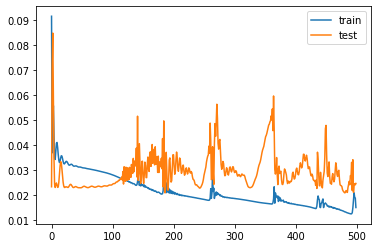

In [115]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [116]:
# make a prediction
ypred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], num_lag_days*num_predictors))

ValueError: ignored

In [102]:
ypred

array([[0.49024248],
       [0.36378235],
       [0.29103014],
       [0.31837642],
       [0.3382796 ],
       [0.45075625],
       [0.5925246 ],
       [0.5906394 ],
       [0.599585  ],
       [0.46910727],
       [0.41280684],
       [0.33663505],
       [0.3591118 ],
       [0.5150205 ],
       [0.547023  ],
       [0.54864717],
       [0.5110017 ],
       [0.37955257],
       [0.39799467]], dtype=float32)

In [98]:
# invert scaling for forecast
ypred_inv = concatenate((ypred, test_X[:, 1-num_predictors:]), axis=1)
ypred_inv = scaler.inverse_transform(ypred_inv)
ypred_inv = ypred_inv[:,0]

In [99]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_inv = concatenate((test_y, test_X[:, 1-num_predictors:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [100]:
y_inv

array([14.      , 14.      , 13.000001, 14.      , 12.      , 10.      ,
       14.      , 12.      , 14.      , 13.000001, 14.      , 12.      ,
        9.      , 14.      , 14.      , 13.000001, 14.      , 11.      ,
       14.      ], dtype=float32)

In [104]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_inv, ypred_inv))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.570


In [105]:
# calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_inv, ypred_inv)
print('Test MSE: %.3f' % mae)

Test MSE: 1.287


In [106]:
# claculate mean absolute percentage error
mape=abs((y_inv-ypred_inv)/y_inv).mean()
print ('\033[34m', '\033[1m','Test MAPE:{:.2f}'.format(
       (abs((y_inv-ypred_inv)/y_inv).mean())))

  Test MAPE:0.10


In [107]:
#Accuracy 
print ('\033[34m', '\033[1m','*Accuracy:{:.0f}'.format(100-(mape*100)))

  *Accuracy:90



 ### <span style="color:green">The model forecast the fuel consumption for 19 days with high accuracy. It is an excellent model, considering the fact that the model is trained for only  4.3 months.</span>


In [159]:
# Convert Actual and Predicted to DataFrame
df_y_inv = pd.DataFrame(y_inv)
df_ypred_inv = pd.DataFrame(ypred_inv) 
# set index 
idx= pd.DataFrame((Data.iloc[-(len(test)):]).index)
# concatenate
Actual_Forcast_Test = pd.DataFrame(concatenate((idx, df_y_inv, df_ypred_inv), axis=1))
Actual_Forcast_Test.columns = ['Date','Actual', 'Forecasted']
Actual_Forcast_Test = Actual_Forcast_Test.set_index('Date')
Actual_Forcast_Test.head(2)

ValueError: ignored

For better visualization, the actual fuel consumed which are hold to test the model performance and the corresponding forecasted values are plotted.

In [158]:
Actual_Forcast_Tes

NameError: ignored

Text(0.5, 1.0, 'Forecasted vs Actual Fuel Consumption')

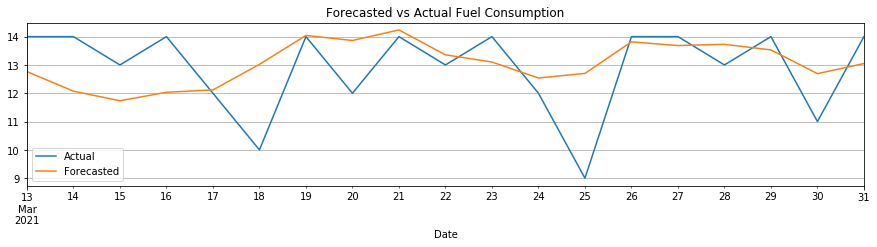

In [ ]:
# plot the charts 
fig, (ax) = plt.subplots(figsize=(15,3))
Actual_Forcast_Test.Actual.plot()
Actual_Forcast_Test.Forecasted.plot()
ax.grid(True)
ax.legend()
ax.set_title('Forecasted vs Actual Fuel Consumption')


#### The forecasted has the same trend as the actual fuel consumption in the majority of instances.

Let's calculate the total sum of the actual and the forecasted fuel consumption during the test period.

In [ ]:
# Calculate the total sum of the actual and the forecasted fuel consumption during the test period 
Actual_Forcast_Test.sum()

Actual        245.000003
Forecasted    248.091556
dtype: float64

In [109]:
test_X[0]

array([0.59999996, 0.42833853, 0.51024437, 0.5164883 , 0.79848665,
       0.40000004, 0.756526  , 0.4660728 , 0.27328962, 0.606952  ,
       0.7       , 0.8310785 , 0.5391183 , 0.44556314, 0.87090117,
       0.        , 0.8261721 , 0.48170424, 0.        , 0.4364856 ,
       0.3       , 0.6079335 , 0.35522437, 0.24543023, 0.6911952 ,
       0.59999996, 0.591975  , 0.29199004, 0.4571424 , 0.85306865,
       0.59999996, 0.7672956 , 0.5291834 , 0.40072286, 0.78645533,
       0.50000006, 0.73071885, 0.55844593, 0.34602207, 0.71117467,
       0.19999999, 0.84514403, 0.6121249 , 0.12381452, 0.540551  ,
       0.19999999, 0.6190214 , 0.6777444 , 0.17400128, 0.6374871 ,
       0.50000006, 0.7610531 , 0.74357414, 0.33736283, 0.7522147 ,
       0.40000004, 0.761812  , 0.78406405, 0.271909  , 0.60402364,
       0.8       , 0.7788024 , 0.7641852 , 0.52699375, 0.96964556,
       0.40000004, 0.8326714 , 0.8544898 , 0.2538612 , 0.58176476,
       0.50000006, 0.8905549 , 0.9014828 , 0.30228186, 0.71563

In [139]:
a =  np.reshape(test_X[0],(1,25,5))

In [143]:
ypred = model.predict(a)

In [144]:
a.reshape((a.shape[0], num_lag_days*num_predictors))

array([[0.59999996, 0.42833853, 0.51024437, 0.5164883 , 0.79848665,
        0.40000004, 0.756526  , 0.4660728 , 0.27328962, 0.606952  ,
        0.7       , 0.8310785 , 0.5391183 , 0.44556314, 0.87090117,
        0.        , 0.8261721 , 0.48170424, 0.        , 0.4364856 ,
        0.3       , 0.6079335 , 0.35522437, 0.24543023, 0.6911952 ,
        0.59999996, 0.591975  , 0.29199004, 0.4571424 , 0.85306865,
        0.59999996, 0.7672956 , 0.5291834 , 0.40072286, 0.78645533,
        0.50000006, 0.73071885, 0.55844593, 0.34602207, 0.71117467,
        0.19999999, 0.84514403, 0.6121249 , 0.12381452, 0.540551  ,
        0.19999999, 0.6190214 , 0.6777444 , 0.17400128, 0.6374871 ,
        0.50000006, 0.7610531 , 0.74357414, 0.33736283, 0.7522147 ,
        0.40000004, 0.761812  , 0.78406405, 0.271909  , 0.60402364,
        0.8       , 0.7788024 , 0.7641852 , 0.52699375, 0.96964556,
        0.40000004, 0.8326714 , 0.8544898 , 0.2538612 , 0.58176476,
        0.50000006, 0.8905549 , 0.9014828 , 0.30

In [145]:
# make a prediction
ypred = model.predict(a)
a = a.reshape((a.shape[0], num_lag_days*num_predictors))
a.shape
# # invert scaling for forecast
# ypred_inv = concatenate((ypred, test_X[:, 1-num_predictors:]), axis=1)
# ypred_inv = scaler.inverse_transform(ypred_inv)
# ypred_inv = ypred_inv[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# y_inv = concatenate((test_y, test_X[:, 1-num_predictors:]), axis=1)
# y_inv = scaler.inverse_transform(y_inv)
# y_inv = y_inv[:,0]

(1, 125)

In [152]:
a

array([[0.59999996, 0.42833853, 0.51024437, 0.5164883 , 0.79848665,
        0.40000004, 0.756526  , 0.4660728 , 0.27328962, 0.606952  ,
        0.7       , 0.8310785 , 0.5391183 , 0.44556314, 0.87090117,
        0.        , 0.8261721 , 0.48170424, 0.        , 0.4364856 ,
        0.3       , 0.6079335 , 0.35522437, 0.24543023, 0.6911952 ,
        0.59999996, 0.591975  , 0.29199004, 0.4571424 , 0.85306865,
        0.59999996, 0.7672956 , 0.5291834 , 0.40072286, 0.78645533,
        0.50000006, 0.73071885, 0.55844593, 0.34602207, 0.71117467,
        0.19999999, 0.84514403, 0.6121249 , 0.12381452, 0.540551  ,
        0.19999999, 0.6190214 , 0.6777444 , 0.17400128, 0.6374871 ,
        0.50000006, 0.7610531 , 0.74357414, 0.33736283, 0.7522147 ,
        0.40000004, 0.761812  , 0.78406405, 0.271909  , 0.60402364,
        0.8       , 0.7788024 , 0.7641852 , 0.52699375, 0.96964556,
        0.40000004, 0.8326714 , 0.8544898 , 0.2538612 , 0.58176476,
        0.50000006, 0.8905549 , 0.9014828 , 0.30

In [149]:
a[:, 1-num_predictors:]

array([[0.8464775 , 0.8539498 , 0.31389165, 0.65446883]], dtype=float32)

In [153]:
ypred_inv = concatenate((ypred, a[:, 1-num_predictors:]), axis=1)
print(ypred_inv)
ypred_inv = scaler.inverse_transform(ypred_inv)
print(ypred_inv)
ypred_inv = ypred_inv[:,0]
print(ypred_inv)
# # invert scaling for actual
# a = a.reshape((len(a), 1))
# print(a)
# # y_inv = concatenate((test_y, test_X[:, 1-num_predictors:]), axis=1)
# y_inv = scaler.inverse_transform(y_inv)
# y_inv = y_inv[:,0]

[[0.4902426  0.8464775  0.8539498  0.31389165 0.65446883]]
[[1.2902427e+01 3.2492468e+02 3.0492405e+01 4.0009271e-02 6.6970466e-03]]
[12.902427]


In [162]:
from pickle import dump
dump(scaler, open('/content/drive/MyDrive/scaler.pkl', 'wb'))

In [154]:
test_y

array([0.59999996, 0.59999996, 0.50000006, 0.59999996, 0.40000004,
       0.19999999, 0.59999996, 0.40000004, 0.59999996, 0.50000006,
       0.59999996, 0.40000004, 0.10000002, 0.59999996, 0.59999996,
       0.50000006, 0.59999996, 0.3       , 0.59999996], dtype=float32)

In [155]:
a[:, 1-num_predictors:]

array([[0.8464775 , 0.8539498 , 0.31389165, 0.65446883]], dtype=float32)

In [161]:
model.save('/content/drive/MyDrive/test.h5')

In [157]:

# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
y_inv = concatenate((test_y, a[:, 1-num_predictors:]), axis=1)
# y_inv = scaler.inverse_transform(y_inv)
# y_inv = y_inv[:,0]

ValueError: ignored

fOR MODEL DEPLOYMENT 


In [ ]:
import keras
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')


new_model = tf.keras.models.load_model('/content/drive/MyDrive/test.h5')
import numpy as np
a = np.array([0.59999996, 0.42833853, 0.51024437, 0.5164883 , 0.79848665,
       0.40000004, 0.756526  , 0.4660728 , 0.27328962, 0.606952  ,
       0.7       , 0.8310785 , 0.5391183 , 0.44556314, 0.87090117,
       0.        , 0.8261721 , 0.48170424, 0.        , 0.4364856 ,
       0.3       , 0.6079335 , 0.35522437, 0.24543023, 0.6911952 ,
       0.59999996, 0.591975  , 0.29199004, 0.4571424 , 0.85306865,
       0.59999996, 0.7672956 , 0.5291834 , 0.40072286, 0.78645533,
       0.50000006, 0.73071885, 0.55844593, 0.34602207, 0.71117467,
       0.19999999, 0.84514403, 0.6121249 , 0.12381452, 0.540551  ,
       0.19999999, 0.6190214 , 0.6777444 , 0.17400128, 0.6374871 ,
       0.50000006, 0.7610531 , 0.74357414, 0.33736283, 0.7522147 ,
       0.40000004, 0.761812  , 0.78406405, 0.271909  , 0.60402364,
       0.8       , 0.7788024 , 0.7641852 , 0.52699375, 0.96964556,
       0.40000004, 0.8326714 , 0.8544898 , 0.2538612 , 0.58176476,
       0.50000006, 0.8905549 , 0.9014828 , 0.30228186, 0.7156361 ,
       0.        , 0.73500276, 0.8428521 , 0.01565295, 0.3646437 ,
       0.40000004, 0.7023854 , 0.8097179 , 0.28771484, 0.74505883,
       0.7       , 0.8038318 , 0.7673185 , 0.45412254, 0.8659105 ,
       0.7       , 0.82919836, 0.87711453, 0.44614893, 0.8116258 ,
       0.19999999, 0.91230273, 0.823261  , 0.1102953 , 0.60010666,
       0.50000006, 0.8987186 , 0.7809348 , 0.30016726, 0.6592092 ,
       0.3       , 0.6915939 , 0.75293016, 0.2238524 , 0.6819239 ,
       0.50000006, 0.77825594, 0.7517247 , 0.33252943, 0.7283713 ,
       0.59999996, 0.8076215 , 0.74569416, 0.38866377, 0.77161413,
       0.50000006, 0.8464775 , 0.8539498 , 0.31389165, 0.65446883])
a =  np.reshape(a,(1,25,5))
ypred = new_model.predict(a)
ypred
a = a.reshape((a.shape[0], 25*5))
a.shape
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
scaler = MinMaxScaler(feature_range=(0, 1))
from pickle import load
scaler = load(open('/content/drive/MyDrive/scaler.pkl', 'rb'))
ypred_inv = concatenate((ypred, a[:, 1-5:]), axis=1)
print(ypred_inv)
ypred_inv = scaler.inverse_transform(ypred_inv)
ypred_inv = ypred_inv[:,0]
ypred_inv